In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import torch
import matplotlib.pyplot as plt
from src import models, data
from tqdm.auto import tqdm
import json

In [3]:
device = "cuda:0"
mt = models.load_model("gptj", device=device)
print(
    f"dtype: {mt.model.dtype}, device: {mt.model.device}, memory: {mt.model.get_memory_footprint()}"
)

dtype: torch.float16, device: cuda:0, memory: 12219206136


In [4]:
mt.__dict__.keys()

dict_keys(['model', 'tokenizer', 'vocab_size', 'n_layer', 'n_embd', 'n_attn_head', 'max_seq_length', 'layer_name_format', 'layer_names', 'mlp_module_name_format', 'attn_module_name_format', 'ln_f_name', 'unembedder_name', 'embedder_name', 'model_type'])

In [5]:
prompt = "The Space Needle is located in the city of"
tokenized = mt.tokenizer(prompt, return_tensors="pt", padding=True).to(mt.model.device)

In [6]:
import baukit

with baukit.TraceDict(
    mt.model,
    mt.layer_names,
) as traces:
    output = mt.model(**tokenized)

In [7]:
output.logits[0][-1].shape

torch.Size([50400])

In [8]:
def untuple(x):
    if isinstance(x, tuple):
        return x[0]
    return x


def interpret_logits(mt, logits, top_k=10):
    token_ids = logits.topk(dim=-1, k=top_k).indices.squeeze().tolist()
    logit_values = logits.topk(dim=-1, k=top_k).values.squeeze().tolist()
    return [
        (mt.tokenizer.decode(t), round(v, 3)) for t, v in zip(token_ids, logit_values)
    ]


def logit_lens(
    mt,
    h,
    interested_tokens=[],
    get_proba=False,
):
    logits = mt.lm_head(h)
    logits = torch.nn.functional.softmax(logits, dim=-1) if get_proba else logits
    candidates = interpret_logits(mt, logits)
    interested_logits = {
        t.item(): (logits[t].item(), mt.tokenizer.decode(t)) for t in interested_tokens
    }
    return candidates, interested_logits


# interpret_logits(mt, output.logits[0][-1])

In [9]:
# interested_words = [" Seattle", " Paris", " Dhaka"]
# int_tokenized = mt.tokenizer(interested_words, return_tensors="pt", padding=True).to(
#     mt.model.device
# )
# int_tokenized.input_ids

# z = untuple(traces[mt.layer_names[-1]].output)[0][-1]
# print(z.shape)

# logit_lens(mt, z, [t[0] for t in int_tokenized.input_ids], get_proba=False)

In [10]:
def filter_by_model_knowledge(mt, relation_prompt, relation_samples):
    model_knows = []
    for sample in relation_samples:
        tokenized = relation_prompt.format(sample.subject)
        output = mt.model(
            **mt.tokenizer(tokenized, return_tensors="pt", padding=True).to(
                mt.model.device
            )
        )

        object_id = output.logits[0][-1].argmax().item()
        object = mt.tokenizer.decode(object_id)

        tick = sample.object.strip().startswith(object.strip())
        # print(object, sample.object, tick)

        if tick:
            model_knows.append(sample)

    return model_knows

In [11]:
dataset = data.load_dataset()
capital_cities = dataset[0]
capital_cities.__dict__.keys()

dict_keys(['name', 'prompt_templates', 'samples', '_domain', '_range'])

In [12]:
import numpy as np

icl_indices = np.random.choice(range(len(capital_cities.samples)), 3, replace=False)
icl_samples = [capital_cities.samples[i] for i in icl_indices]
icl_prompt = [
    f"{capital_cities.prompt_templates[0].format(sample.subject)} {sample.object}"
    for sample in icl_samples
]
icl_prompt = "\n".join(icl_prompt) + "\n" + capital_cities.prompt_templates[0]

print(icl_prompt)

The capital city of Germany is Berlin
The capital city of Argentina is Buenos Aires
The capital city of Japan is Tokyo
The capital city of {} is


In [13]:
model_knows = filter_by_model_knowledge(mt, icl_prompt, capital_cities.samples)
len(model_knows)

24

## Layer Richness based on logit lens

In [14]:
def layer_richness(mt, relation_prompt, subject, verbose=False):
    tokenized = relation_prompt.format(subject)
    with baukit.TraceDict(mt.model, layers=mt.layer_names) as traces:
        output = mt.model(
            **mt.tokenizer(tokenized, return_tensors="pt", padding=True).to(
                mt.model.device
            )
        )

    object_id = output.logits[0][-1].argmax().item()
    object = mt.tokenizer.decode(object_id)
    # base_logit = output.logits[0][-1][object_id].item()
    base_score = torch.nn.functional.softmax(output.logits[0][-1], dim=-1)[
        object_id
    ].item()

    if verbose:
        print(f"object ==> {object} [{object_id}], base = {base_score}")

    layer_contributions = {}

    prev_score = 0
    for layer in mt.layer_names:
        h = untuple(traces[layer].output)[0][-1]
        candidates, interested_logits = logit_lens(
            mt, h, torch.tensor([object_id]), get_proba=True
        )
        layer_score = interested_logits[object_id][0]
        cur_layer_contribution = (layer_score - base_score) / base_score

        layer_contributions[layer] = cur_layer_contribution

        if verbose:
            print(f"layer: {layer}, diff: {cur_layer_contribution}")

        prev_score = layer_score

    return layer_contributions


relation_prompt = mt.tokenizer.eos_token + " {} is located in the city of"
subject = "The Space Needle"
layer_richness(mt, relation_prompt, subject, verbose=True)

object ==>  Seattle [7312], base = 0.959947407245636
layer: transformer.h.0, diff: -0.9999819934437508
layer: transformer.h.1, diff: -0.9999449868660799
layer: transformer.h.2, diff: -0.9997330062349253
layer: transformer.h.3, diff: -0.9993924960470952
layer: transformer.h.4, diff: -0.9992683129005488
layer: transformer.h.5, diff: -0.9986031879676466
layer: transformer.h.6, diff: -0.9980647298442216
layer: transformer.h.7, diff: -0.9917025788803585
layer: transformer.h.8, diff: -0.9964394208222228
layer: transformer.h.9, diff: -0.9944048041492073
layer: transformer.h.10, diff: -0.9894931123370058
layer: transformer.h.11, diff: -0.9941703463685277
layer: transformer.h.12, diff: -0.772758750332578
layer: transformer.h.13, diff: -0.7910703003897177
layer: transformer.h.14, diff: -0.7464358971254396
layer: transformer.h.15, diff: -0.7390604116857583
layer: transformer.h.16, diff: 0.030024690714112078
layer: transformer.h.17, diff: 0.034602578228397025
layer: transformer.h.18, diff: 0.03205

{'transformer.h.0': -0.9999819934437508,
 'transformer.h.1': -0.9999449868660799,
 'transformer.h.2': -0.9997330062349253,
 'transformer.h.3': -0.9993924960470952,
 'transformer.h.4': -0.9992683129005488,
 'transformer.h.5': -0.9986031879676466,
 'transformer.h.6': -0.9980647298442216,
 'transformer.h.7': -0.9917025788803585,
 'transformer.h.8': -0.9964394208222228,
 'transformer.h.9': -0.9944048041492073,
 'transformer.h.10': -0.9894931123370058,
 'transformer.h.11': -0.9941703463685277,
 'transformer.h.12': -0.772758750332578,
 'transformer.h.13': -0.7910703003897177,
 'transformer.h.14': -0.7464358971254396,
 'transformer.h.15': -0.7390604116857583,
 'transformer.h.16': 0.030024690714112078,
 'transformer.h.17': 0.034602578228397025,
 'transformer.h.18': 0.03205930738712761,
 'transformer.h.19': 0.04172373658395138,
 'transformer.h.20': 0.04172373658395138,
 'transformer.h.21': 0.04172373658395138,
 'transformer.h.22': 0.04172373658395138,
 'transformer.h.23': 0.0412150824156975,
 '

In [16]:
layer_richness_info = {layer: [] for layer in mt.layer_names}

for sample in tqdm(model_knows):
    cur_richness = layer_richness(mt, icl_prompt, sample.subject)
    for layer in mt.layer_names:
        layer_richness_info[layer].append(cur_richness[layer])

# with open("layer_sweep/layer_contribution_info.json", "w") as f:
with open("layer_sweep/layer_completeness_info.json", "w") as f:
    json.dump(layer_richness_info, f)

for layer in mt.layer_names:
    layer_richness_info[layer] = np.array(layer_richness_info[layer])

  0%|          | 0/24 [00:00<?, ?it/s]

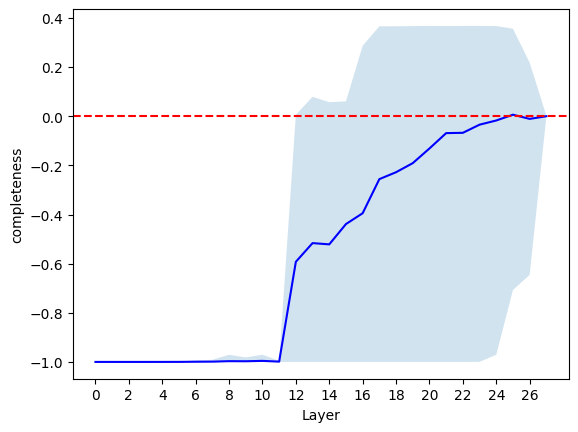

In [17]:
mean_richness = [layer_richness_info[layer].mean() for layer in mt.layer_names]
low_richness = [layer_richness_info[layer].min() for layer in mt.layer_names]
high_richness = [layer_richness_info[layer].max() for layer in mt.layer_names]

plt.plot(mean_richness, color="blue")
plt.fill_between(range(len(mean_richness)), low_richness, high_richness, alpha=0.2)
plt.axhline(0, color="red", linestyle="--")

plt.xlabel("Layer")
plt.ylabel("completeness")
plt.xticks(range(0, len(mean_richness), 2))

plt.show()

## Layer Richness based on `Jh_norm` and `J_norm`

In [18]:
import copy

capital_cities_known = copy.deepcopy(capital_cities.__dict__)
capital_cities_known["samples"] = model_knows

capital_cities_known = data.Relation(**capital_cities_known)

5

In [20]:
from src.data import RelationSample
RelationSample(subject="Russia", object="Moscow")

RelationSample(subject='Russia', object='Moscow')

In [21]:
print(icl_prompt)

The capital city of Chile is Santiago
The capital city of Nigeria is Abuja
The capital city of Mexico is Mexico City
The capital city of {} is


In [22]:
from src.operators import JacobianEstimator, JacobianIclMeanEstimator

# mean_estimator = JacobianIclMeanEstimator(
#     mt=mt,
#     h_layer=12,
# )

# operator = mean_estimator(capital_cities_subset)
# operator("Russia", k = 10).predictions

In [23]:
estimator = JacobianEstimator(
    mt=mt,
    h_layer=12,
)

operator = estimator.call_on_sample(
    sample = RelationSample(subject="Russia", object="Moscow"),
    prompt_template= icl_prompt
)

In [24]:
operator.misc["Jh"].norm()

tensor(18.4844, device='cuda:0', dtype=torch.float16,
       grad_fn=<LinalgVectorNormBackward0>)

In [25]:
relation_prompt = icl_prompt
subject = "Russia"
layer_richness(mt, relation_prompt, subject, verbose=True)

object ==>  Moscow [9070], base = 0.984585702419281
layer: transformer.h.0, diff: 7.264535078532953e-07
layer: transformer.h.1, diff: 1.210755846422159e-07
layer: transformer.h.2, diff: -5.448401308899715e-07
layer: transformer.h.3, diff: -1.210755846422159e-07
layer: transformer.h.4, diff: 2.05828493891767e-06
layer: transformer.h.5, diff: 1.6587355095983578e-05
layer: transformer.h.6, diff: 0.00012101504684989479
layer: transformer.h.7, diff: 0.00020159084842928947
layer: transformer.h.8, diff: 0.00037291280069802496
layer: transformer.h.9, diff: 0.001288728522931746
layer: transformer.h.10, diff: 0.0055791629403133085
layer: transformer.h.11, diff: -0.005447432704222577
layer: transformer.h.12, diff: 0.9525219650785324
layer: transformer.h.13, diff: 0.050584410658840666
layer: transformer.h.14, diff: 0.004463330352250647
layer: transformer.h.15, diff: 0.0014877767840835489
layer: transformer.h.16, diff: -0.006942958325723229
layer: transformer.h.17, diff: 0.011406288677973875
layer:

{'transformer.h.0': 7.264535078532953e-07,
 'transformer.h.1': 1.210755846422159e-07,
 'transformer.h.2': -5.448401308899715e-07,
 'transformer.h.3': -1.210755846422159e-07,
 'transformer.h.4': 2.05828493891767e-06,
 'transformer.h.5': 1.6587355095983578e-05,
 'transformer.h.6': 0.00012101504684989479,
 'transformer.h.7': 0.00020159084842928947,
 'transformer.h.8': 0.00037291280069802496,
 'transformer.h.9': 0.001288728522931746,
 'transformer.h.10': 0.0055791629403133085,
 'transformer.h.11': -0.005447432704222577,
 'transformer.h.12': 0.9525219650785324,
 'transformer.h.13': 0.050584410658840666,
 'transformer.h.14': 0.004463330352250647,
 'transformer.h.15': 0.0014877767840835489,
 'transformer.h.16': -0.006942958325723229,
 'transformer.h.17': 0.011406288677973875,
 'transformer.h.18': 0.0,
 'transformer.h.19': 0.0,
 'transformer.h.20': 0.0,
 'transformer.h.21': 0.0,
 'transformer.h.22': 0.0,
 'transformer.h.23': 0.0,
 'transformer.h.24': 0.0,
 'transformer.h.25': -0.00049592559469

In [35]:
layerwise_jh = {layer: [] for layer in mt.layer_names}

for sample in tqdm(set(model_knows) - set(icl_samples)):
    for h_layer in range(0, 24):
        layer_name = mt.layer_name_format.format(h_layer)
        estimator = JacobianEstimator(
            mt=mt,
            h_layer=h_layer,
        )
        operator = estimator.call_on_sample(
            # sample = RelationSample(subject="Russia", object="Moscow"),
            sample = sample,
            prompt_template= icl_prompt
        )

        # print(h_layer, " ===> ", f"J:{operator.weight.norm().item()},  Jh: {operator.misc['Jh'].norm().item()}")
        layerwise_jh[layer_name].append({
            "J": operator.weight.norm().item(),
            "Jh": operator.misc['Jh'].norm().item(),
            "bias": operator.bias.norm().item()
        })

  0%|          | 0/21 [00:00<?, ?it/s]

In [39]:
for layer in mt.layer_names:
    if layer in layerwise_jh and len(layerwise_jh[layer]) == 0:
        layerwise_jh.pop(layer)

with open("layer_sweep/layer_jh_info.json", "w") as f:
    json.dump(layerwise_jh, f)

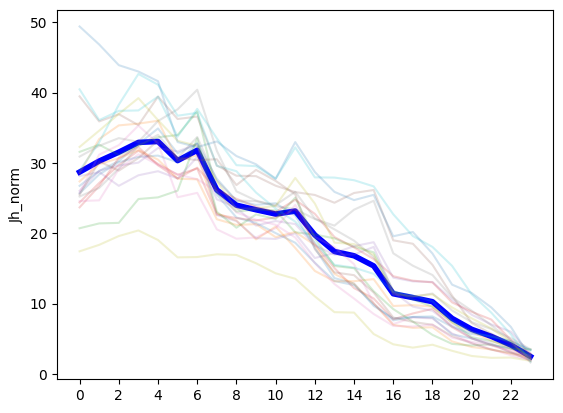

In [59]:
key = "Jh"

info = {
    layer: np.array([layerwise_jh[layer][i][key] for i in range(len(layerwise_jh[layer]))])
    for layer in layerwise_jh.keys()
}

mean = [info[layer].mean() for layer in info.keys()]
plt.plot(mean, color="blue", linewidth=4)
plt.xticks(range(0, len(mean), 2))
plt.ylabel(f"{key}_norm")

for i in range(len(set(model_knows) - set(icl_samples))):
    arr = []
    for layer in layerwise_jh.keys():
        arr.append(layerwise_jh[layer][i][key])
    plt.plot(arr, alpha=0.2)

plt.show()

## Layer sweep on mean ICL

In [14]:
import copy

capital_cities_known = copy.deepcopy(capital_cities.__dict__)
capital_cities_known["samples"] = model_knows

capital_cities_known = data.Relation(**capital_cities_known)

In [15]:
indices = np.random.choice(range(len(capital_cities_known.samples)), 2, replace=False)
samples = [capital_cities_known.samples[i] for i in indices]

capital_cities_subset = copy.deepcopy(capital_cities.__dict__)
capital_cities_subset["samples"] = samples
capital_cities_subset = data.Relation(**capital_cities_subset)

len(capital_cities_subset.samples)

2

In [16]:
from src.operators import JacobianIclMeanEstimator

mean_estimator = JacobianIclMeanEstimator(
    mt=mt,
    h_layer=12,
)

operator = mean_estimator(capital_cities_subset)

In [17]:
operator("Chile", k = 10).predictions

[PredictedObject(token=' Santiago', prob=0.9643852710723877),
 PredictedObject(token=' Chile', prob=0.020650528371334076),
 PredictedObject(token=' Cal', prob=0.0017217925051227212),
 PredictedObject(token=' Cap', prob=0.0009361222619190812),
 PredictedObject(token=' La', prob=0.0008725619409233332),
 PredictedObject(token=' Monte', prob=0.0007177499355748296),
 PredictedObject(token=' Lag', prob=0.0005812515737488866),
 PredictedObject(token=' Santa', prob=0.0005812515737488866),
 PredictedObject(token=' Car', prob=0.0004894629237242043),
 PredictedObject(token=' Que', prob=0.0003932944964617491)]

In [18]:
predictions = []
target = []

for sample in tqdm(set(capital_cities_known.samples)):
    cur_predictions = operator(sample.subject, k = 5).predictions
    predictions.append([
        p.token for p in cur_predictions
    ])
    target.append(sample.object)

  0%|          | 0/24 [00:00<?, ?it/s]

In [23]:
from src.metrics import recall

recall(predictions, target)

[0.9166666666666666, 0.9583333333333334, 0.9583333333333334, 1.0, 1.0]

In [24]:
# np.savez("layer_sweep/operator_weight.npz", jacobian = operator.weight.detach().cpu().numpy(), allow_pickle=True)

In [25]:
# j = np.load("layer_sweep/operator_weight.npz", allow_pickle=True)["jacobian"]

In [26]:
# torch.dist(torch.tensor(j).to(device), operator.weight)

In [31]:
def get_layer_wise_recall(capital_cities_subset, verbose = True, save_weights = True):

    layer_wise_recall = {}

    for h_layer in tqdm(range(0, 24)):
        layer_name = mt.layer_name_format.format(h_layer)
        mean_estimator = JacobianIclMeanEstimator(
            mt=mt,
            h_layer=h_layer,
        )
        operator = mean_estimator(capital_cities_subset)
        if(save_weights):
            np.savez(
                f"layer_sweep/weights_and_biases/{layer_name}.npz", 
                jacobian = operator.weight.detach().cpu().numpy(),
                bias = operator.bias.detach().cpu().numpy(), 
                allow_pickle=True
            )

        predictions = []
        target = []

        for sample in set(capital_cities_known.samples) - set(capital_cities_subset.samples):
            cur_predictions = operator(sample.subject, k = 5).predictions
            predictions.append([
                p.token for p in cur_predictions
            ])
            target.append(sample.object)

        layer_wise_recall[layer_name] = recall(predictions, target)
        
        if(verbose):
            print(layer_name, layer_wise_recall[layer_name])
    
    return layer_wise_recall

layer_wise_recall = get_layer_wise_recall(capital_cities_subset, verbose = True, save_weights = True)

  0%|          | 0/24 [00:00<?, ?it/s]

transformer.h.0 [0.6818181818181818, 0.8636363636363636, 1.0, 1.0, 1.0]
transformer.h.1 [0.6363636363636364, 0.8636363636363636, 0.9545454545454546, 1.0, 1.0]
transformer.h.2 [0.9090909090909091, 0.9545454545454546, 1.0, 1.0, 1.0]
transformer.h.3 [0.9090909090909091, 0.9545454545454546, 1.0, 1.0, 1.0]
transformer.h.4 [0.9090909090909091, 1.0, 1.0, 1.0, 1.0]
transformer.h.5 [0.9545454545454546, 1.0, 1.0, 1.0, 1.0]
transformer.h.6 [0.9090909090909091, 1.0, 1.0, 1.0, 1.0]
transformer.h.7 [0.9545454545454546, 1.0, 1.0, 1.0, 1.0]
transformer.h.8 [0.9545454545454546, 1.0, 1.0, 1.0, 1.0]
transformer.h.9 [0.9090909090909091, 0.9545454545454546, 1.0, 1.0, 1.0]
transformer.h.10 [0.9090909090909091, 0.9545454545454546, 0.9545454545454546, 1.0, 1.0]
transformer.h.11 [0.9545454545454546, 0.9545454545454546, 0.9545454545454546, 0.9545454545454546, 1.0]
transformer.h.12 [0.9545454545454546, 0.9545454545454546, 0.9545454545454546, 1.0, 1.0]
transformer.h.13 [0.8636363636363636, 0.9090909090909091, 0.9

In [28]:
with open("layer_sweep/layer_wise_recall.json", "w") as f:
    json.dump(layer_wise_recall, f)

In [33]:
layer_wise_recall_collection = {}
number_of_runs = 10

for run in tqdm(range(number_of_runs)):
    indices = np.random.choice(range(len(capital_cities_known.samples)), 2, replace=False)
    samples = [capital_cities_known.samples[i] for i in indices]

    capital_cities_subset = copy.deepcopy(capital_cities.__dict__)
    capital_cities_subset["samples"] = samples
    capital_cities_subset = data.Relation(**capital_cities_subset)

    layer_wise_recall = get_layer_wise_recall(capital_cities_subset, verbose=False, save_weights=False)

    for layer in layer_wise_recall.keys():
        if(layer not in layer_wise_recall_collection):
            layer_wise_recall_collection[layer] = []
        layer_wise_recall_collection[layer].append(layer_wise_recall[layer])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [35]:
with open("layer_sweep/layer_wise_recall_collection.json", "w") as f:
    json.dump(layer_wise_recall_collection, f)

In [41]:
top_1 = np.array([
    np.array(layer_wise_recall_collection[layer])[:, 0]
    for layer in layer_wise_recall_collection.keys()
])
top_1.mean(axis = 1)

array([0.63181818, 0.65909091, 0.75      , 0.71363636, 0.77272727,
       0.83636364, 0.86363636, 0.86818182, 0.88181818, 0.89545455,
       0.88181818, 0.85      , 0.85909091, 0.85454545, 0.85909091,
       0.85454545, 0.50454545, 0.33181818, 0.31818182, 0.37272727,
       0.37272727, 0.54090909, 0.52727273, 0.48636364])

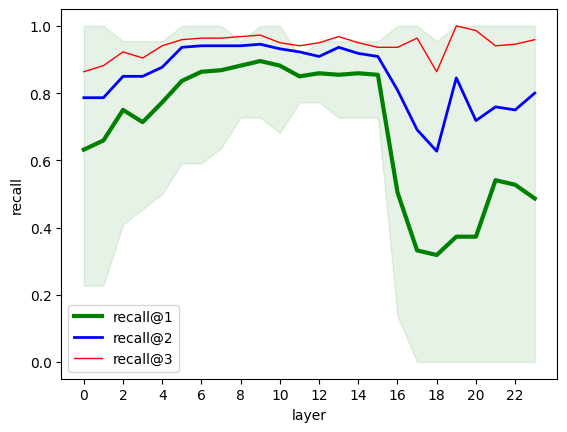

In [44]:
# top_1 = [layer_wise_recall[layer][0] for layer in layer_wise_recall.keys()]
# top_2 = [layer_wise_recall[layer][1] for layer in layer_wise_recall.keys()]
# top_3 = [layer_wise_recall[layer][2] for layer in layer_wise_recall.keys()]

top_1 = np.array([
    np.array(layer_wise_recall_collection[layer])[:, 0]
    for layer in layer_wise_recall_collection.keys()
])

top_2 = np.array([
    np.array(layer_wise_recall_collection[layer])[:, 1]
    for layer in layer_wise_recall_collection.keys()
])

top_3 = np.array([
    np.array(layer_wise_recall_collection[layer])[:, 2]
    for layer in layer_wise_recall_collection.keys()
])




plt.plot(top_1.mean(axis=1), color="green", linewidth=3, label="recall@1")
plt.plot(top_2.mean(axis=1), color="blue", linewidth=2, label="recall@2")
plt.plot(top_3.mean(axis=1), color="red", linewidth=1, label="recall@3")

plt.fill_between(
    range(len(layer_wise_recall_collection.keys())),
    top_1.min(axis=1), top_1.max(axis=1),
    color="green", alpha=0.1
)

plt.xticks(range(0, len(top_1), 2))
plt.xlabel("layer")
plt.ylabel("recall")

plt.legend()
plt.show()

transformer.h.0 torch.Size([4096, 4096])


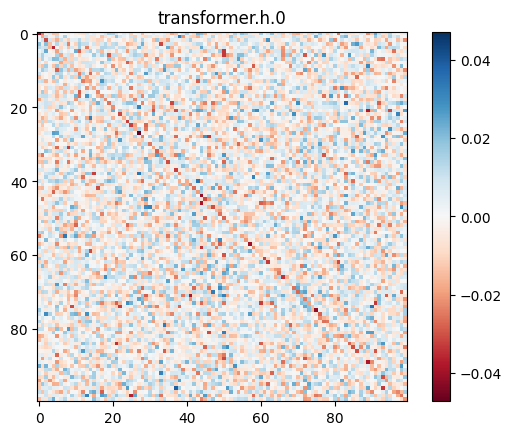

transformer.h.1 torch.Size([4096, 4096])


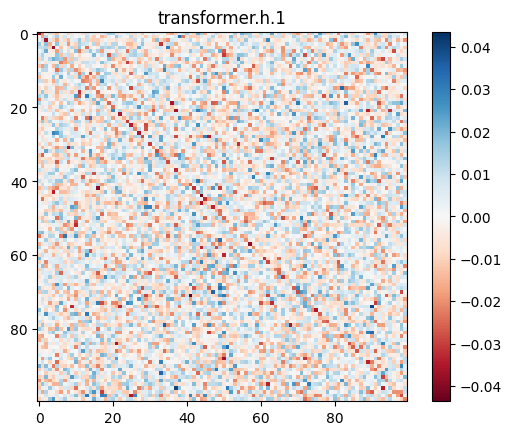

transformer.h.2 torch.Size([4096, 4096])


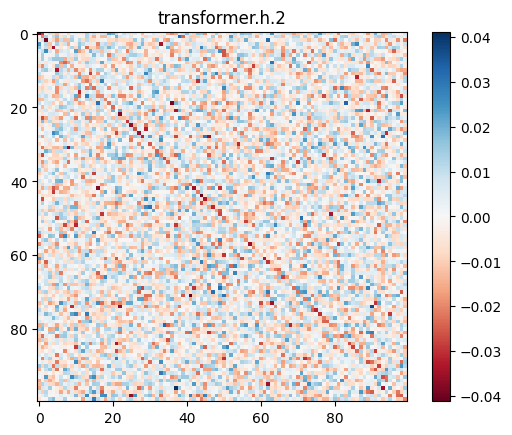

transformer.h.3 torch.Size([4096, 4096])


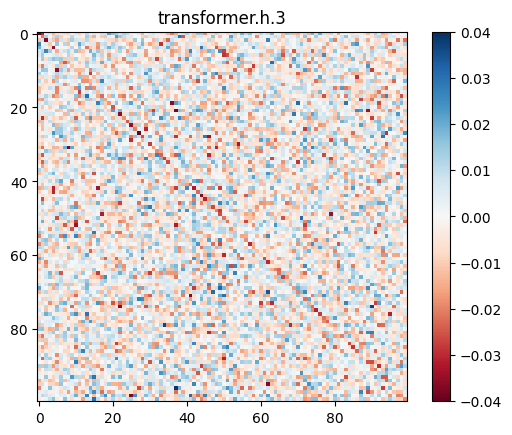

transformer.h.4 torch.Size([4096, 4096])


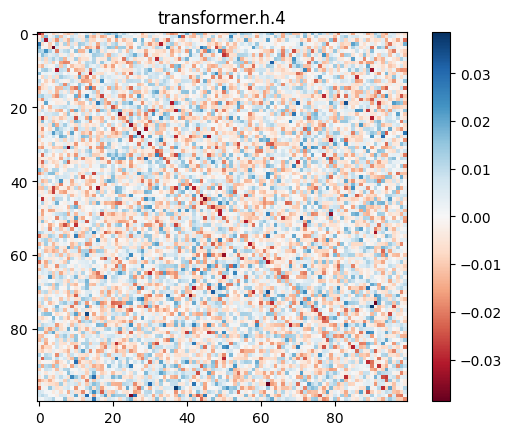

transformer.h.5 torch.Size([4096, 4096])


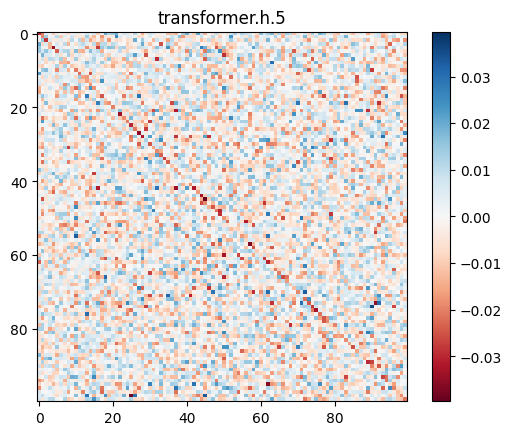

transformer.h.6 torch.Size([4096, 4096])


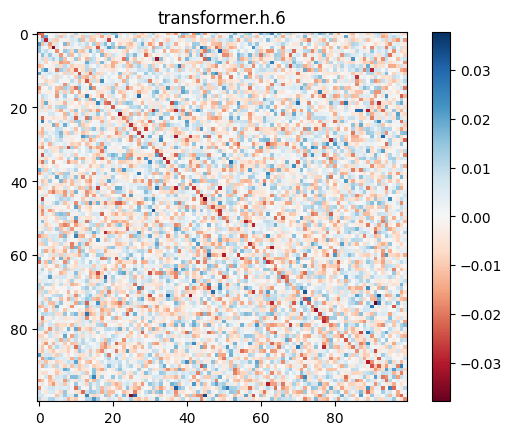

transformer.h.7 torch.Size([4096, 4096])


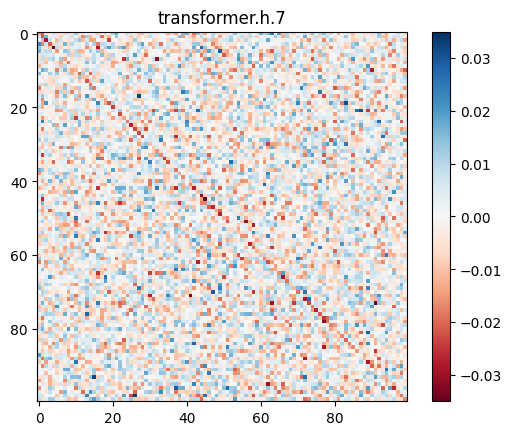

transformer.h.8 torch.Size([4096, 4096])


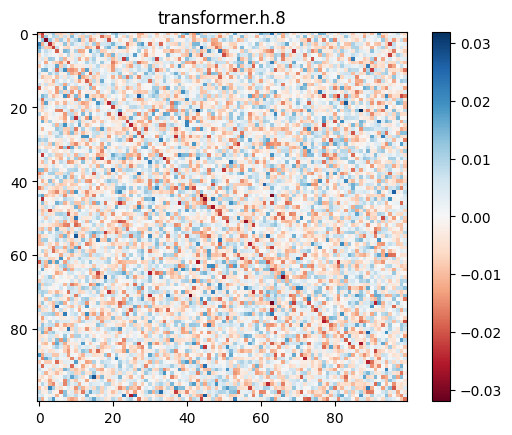

transformer.h.9 torch.Size([4096, 4096])


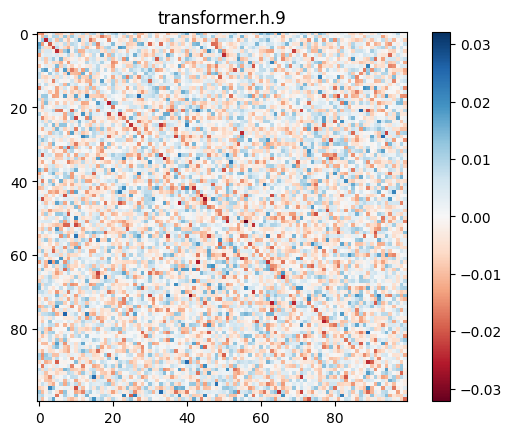

transformer.h.10 torch.Size([4096, 4096])


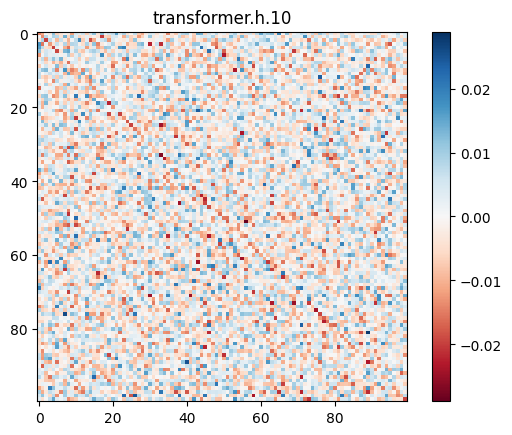

transformer.h.11 torch.Size([4096, 4096])


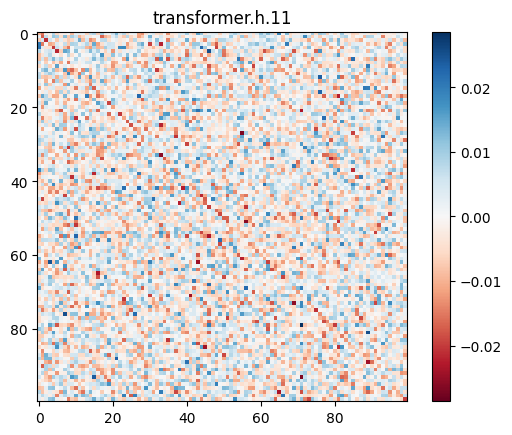

transformer.h.12 torch.Size([4096, 4096])


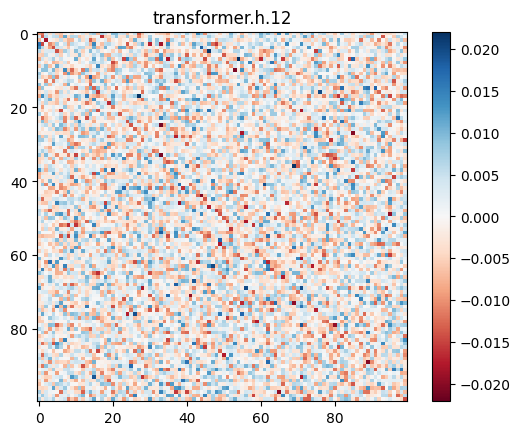

transformer.h.13 torch.Size([4096, 4096])


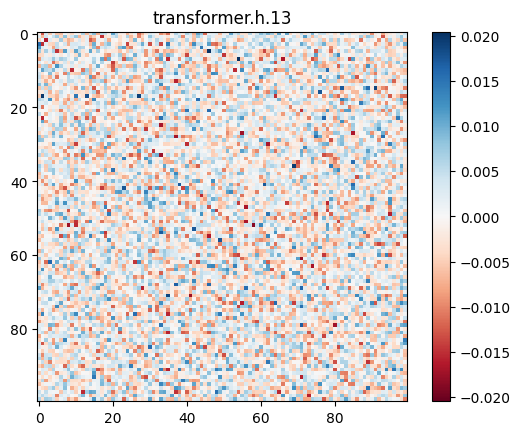

transformer.h.14 torch.Size([4096, 4096])


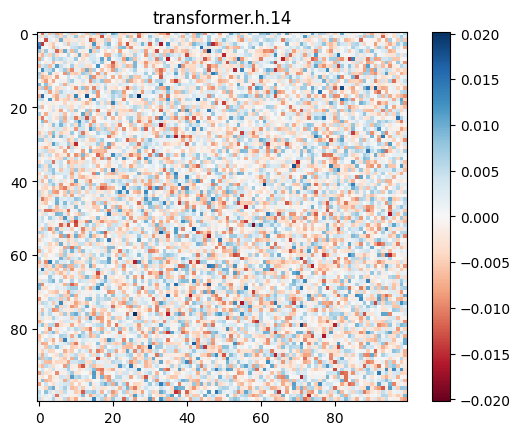

transformer.h.15 torch.Size([4096, 4096])


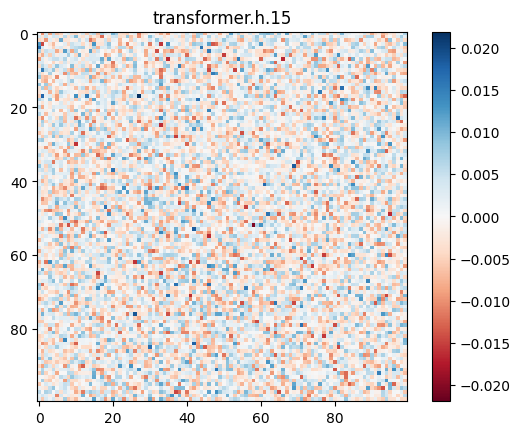

transformer.h.16 torch.Size([4096, 4096])


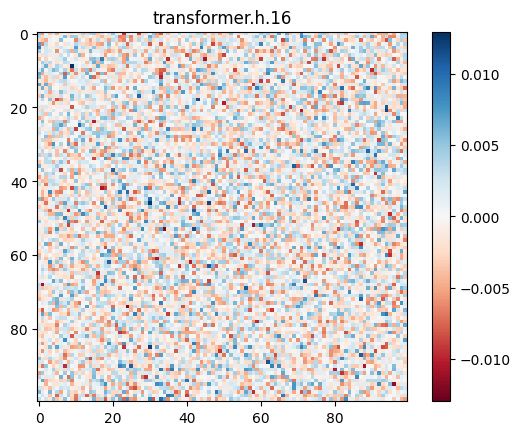

transformer.h.17 torch.Size([4096, 4096])


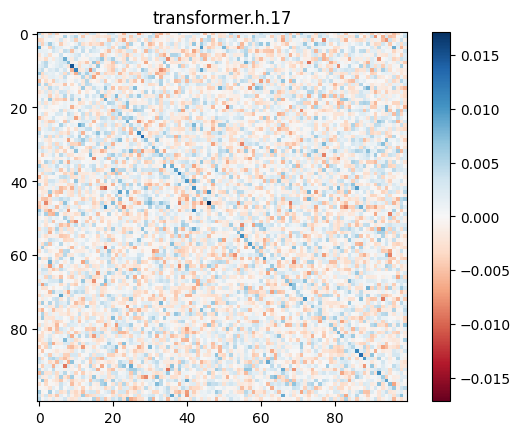

transformer.h.18 torch.Size([4096, 4096])


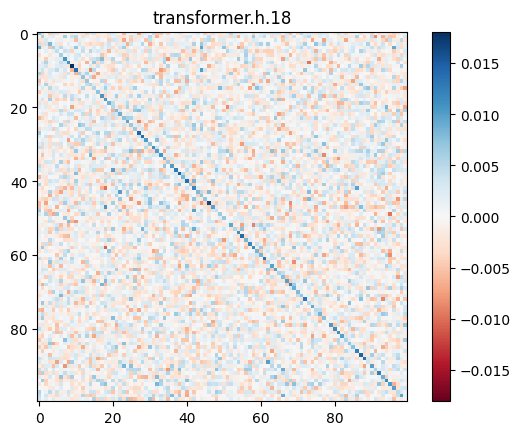

transformer.h.19 torch.Size([4096, 4096])


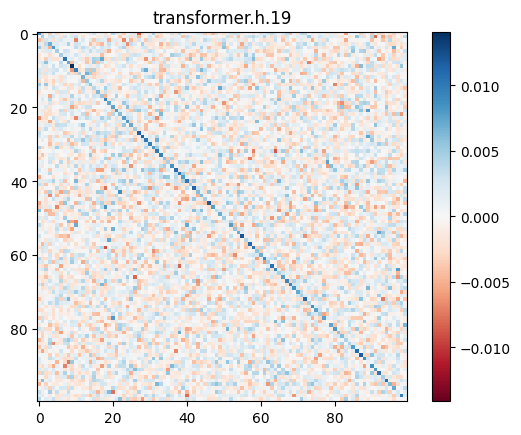

transformer.h.20 torch.Size([4096, 4096])


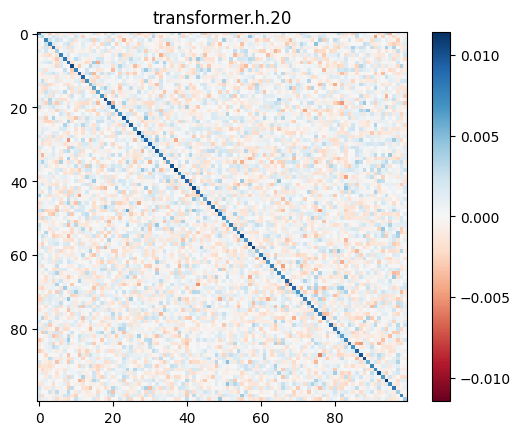

transformer.h.21 torch.Size([4096, 4096])


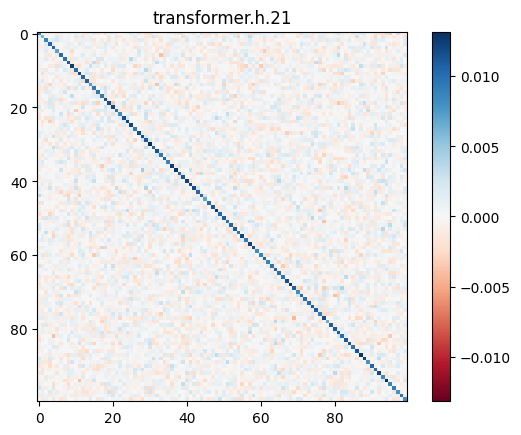

transformer.h.22 torch.Size([4096, 4096])


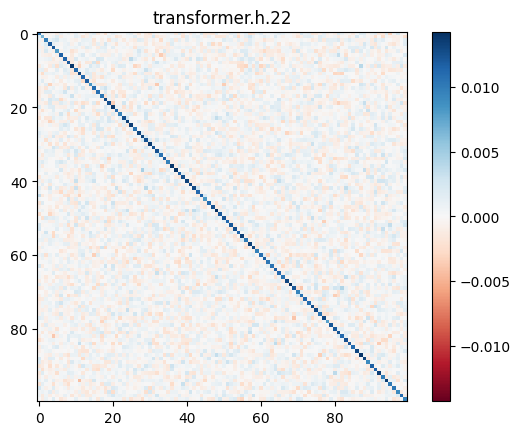

transformer.h.23 torch.Size([4096, 4096])


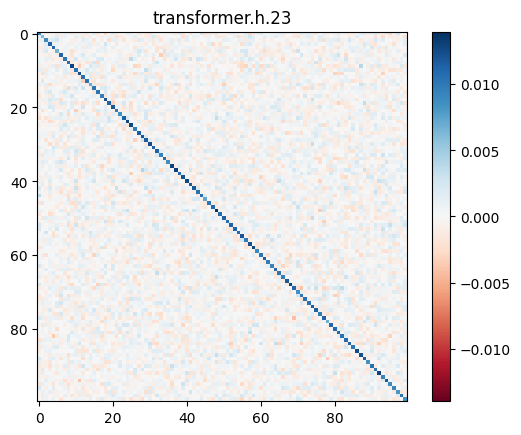

In [30]:
from src.utils.misc import visualize_matrix

for h_layer in range(0, 24):
    layer_name = mt.layer_name_format.format(h_layer)
    j = np.load(f"layer_sweep/weights_and_biases/{layer_name}.npz", allow_pickle=True)["jacobian"]
    j = torch.tensor(j).to(device)
    print(layer_name, j.shape)
    visualize_matrix(j, title = layer_name, save_path=f"layer_sweep/Jacobian_plots/{layer_name}.png")